<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [205]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers#
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 3734 files belonging to 8 classes.


In [5]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [6]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


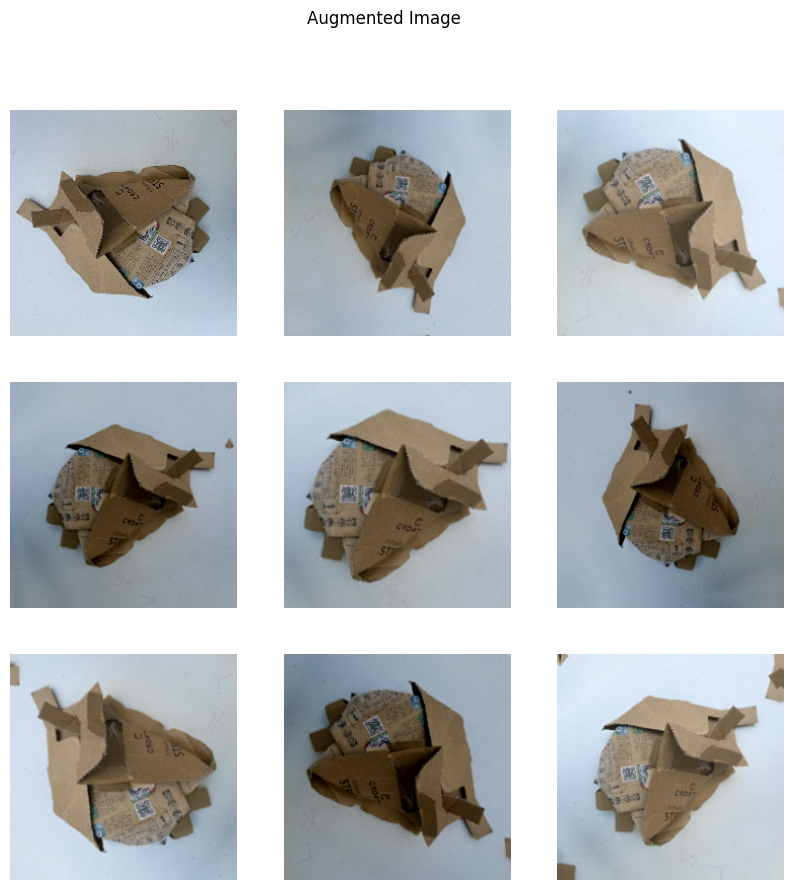

In [7]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [8]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [9]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [10]:

# 1. Shuffle once with seed BEFORE splitting
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

# 2. Split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# 3. Perform split
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


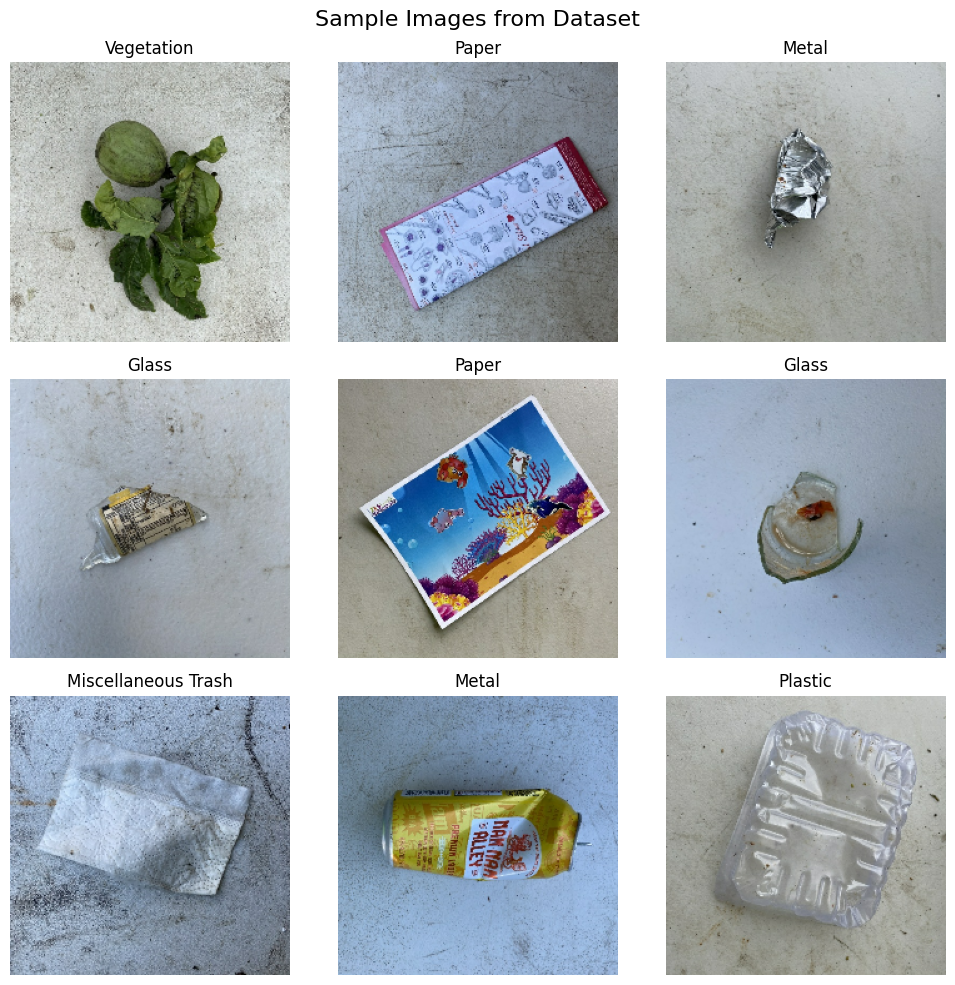

In [11]:


plt.figure(figsize=(10, 10))

    # Take 1 batch
for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]         # Extract one image from the batch
    label_idx = labels[i].numpy()  # Get class index

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Convert to displayable format
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



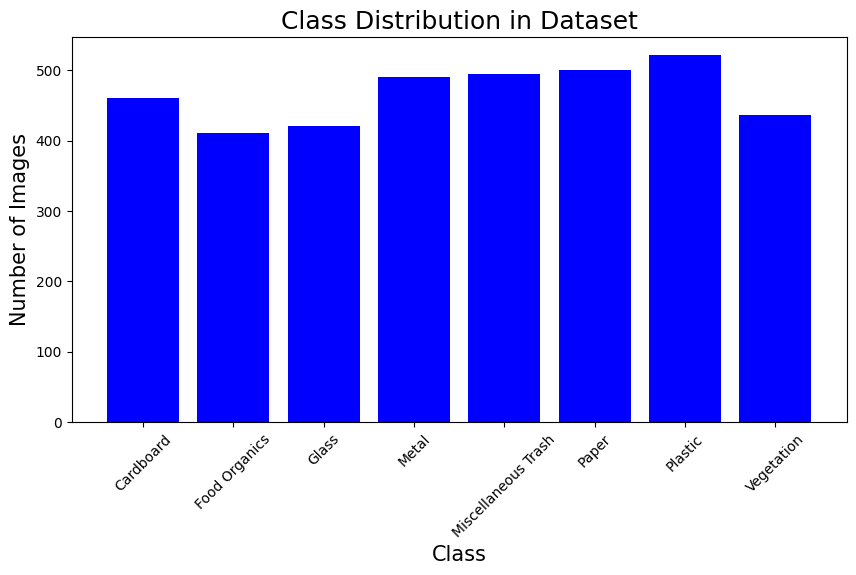

In [12]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [13]:
label_extraction_ds = dataset.shuffle(buffer_size=dataset_size, seed=42).take(train_size)
label_extraction_ds = label_extraction_ds.unbatch().batch(256)

train_labels = []

for batch in label_extraction_ds:
    _, labels = batch

    if tf.rank(labels).numpy() > 1:
        labels = tf.argmax(labels, axis=1)

    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)




Class weights: {0: np.float64(0.9810030395136778), 1: np.float64(1.105308219178082), 2: np.float64(1.1206597222222223), 3: np.float64(0.978030303030303), 4: np.float64(0.911723163841808), 5: np.float64(0.9464809384164223), 6: np.float64(0.8940443213296398), 7: np.float64(1.1245644599303135)}


In [ ]:
@register_keras_serializable()
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

In [44]:
def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)



In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [16]:



input_layer = Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 491,592 (1.88 MB)

 Trainable params: 489,864 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset,  callbacks=[lr_scheduler, reduce_lr])

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 429ms/step - accuracy: 0.2083 - loss: 2.9841 - val_accuracy: 0.1011 - val_loss: 3.5866 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - accuracy: 0.3628 - loss: 2.3450 - val_accuracy: 0.1461 - val_loss: 3.3517 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - accuracy: 0.4303 - loss: 2.0999 - val_accuracy: 0.1305 - val_loss: 3.2629 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.4380 - loss: 2.0339 - val_accuracy: 0.1691 - val_loss: 2.8960 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4546 - loss: 1.9598 - val_accuracy: 0.2610 - val_loss: 2.7367 - learning_rate: 0.0010
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4865 - loss: 1.8691 - val_accuracy: 0.1967 - val_loss: 2.9584 - learning_rate: 9.0484e-04
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.4914 - loss

In [17]:
model.save("/content/drive/MyDrive/my_model.h5")

In [ ]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [ ]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        65
           1       0.51      0.60      0.55        67
           2       0.81      0.51      0.62        67
           3       0.82      0.68      0.74        68
           4       0.37      0.25      0.29        57
           5       0.48      0.81      0.60        70
           6       0.78      0.53      0.63        98
           7       0.52      0.81      0.63        52

    accuracy                           0.61       544
   macro avg       0.63      0.61      0.60       544
weighted avg       0.64      0.61      0.61       544



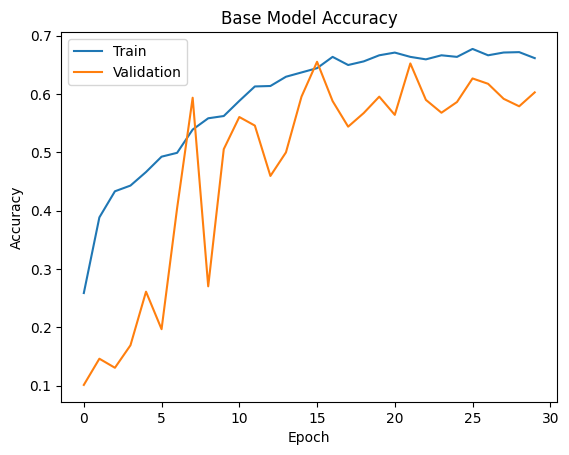

In [ ]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

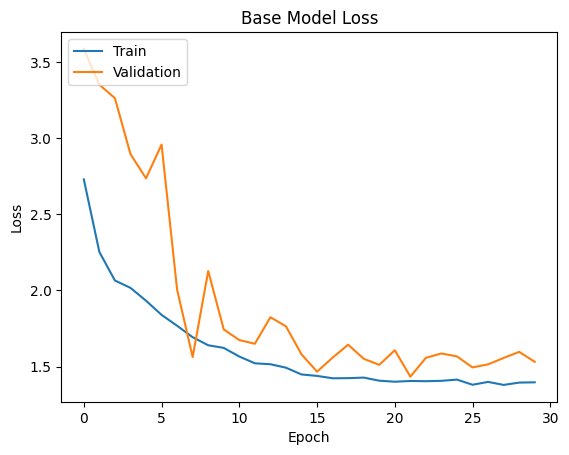

In [ ]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

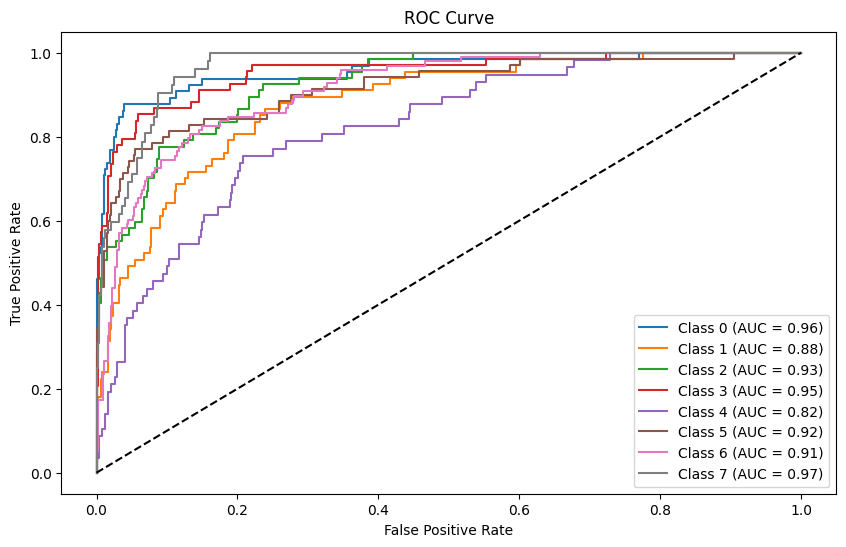

In [ ]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

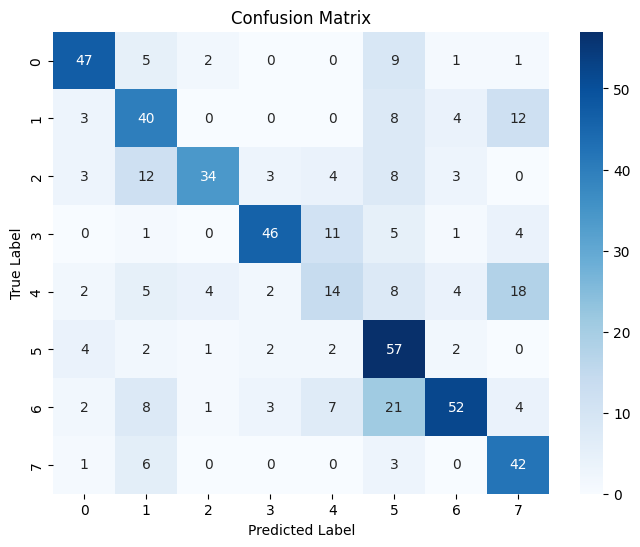

In [ ]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5971 - loss: 1.5364
Test Accuracy: 0.6020
Test Loss: 1.5500


In [18]:
def build_model(hp):
    inputs = Input(shape=(224, 224, 3))

    l2_value = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')

    # Conv Block 1
    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 2
    x = layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Conv Block 3
    x = layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(
        hp.Int("units", min_value=64, max_value=512, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout1', min_value=0.4, max_value=0.8, step=0.1))(x)



    outputs = layers.Dense(8, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
        ),
        loss= CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model


In [45]:
 rm -rf my_tuning/cnn_baseline


In [20]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [24]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_weights_dict, callbacks=[early_stop])


Trial 5 Complete [00h 04m 43s]
val_accuracy: 0.27757352590560913

Best val_accuracy So Far: 0.501838207244873
Total elapsed time: 00h 25m 54s


In [46]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [47]:
print("Initial LR:", best_model.optimizer.learning_rate.numpy())

Initial LR: 1e-04


In [48]:
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler]
)


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 428ms/step - accuracy: 0.2053 - loss: 3.3652 - val_accuracy: 0.1273 - val_loss: 2.1776 - learning_rate: 1.0000e-04
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.2705 - loss: 2.8268 - val_accuracy: 0.1232 - val_loss: 2.2005 - learning_rate: 1.0000e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 449ms/step - accuracy: 0.3083 - loss: 2.7753 - val_accuracy: 0.1379 - val_loss: 2.3287 - learning_rate: 1.0000e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - accuracy: 0.3457 - loss: 2.5822 - val_accuracy: 0.1232 - val_loss: 2.4068 - learning_rate: 1.0000e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.3428 - loss: 2.5565 - val_accuracy: 0.2154 - val_loss: 2.3103 - learning_rate: 1.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.3755 - loss: 2.3856 - val_accuracy: 0.3235 - val_loss: 1.8428 - learning_rate: 9.0484e-05
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - acc

In [70]:
best_model.save("/content/drive/MyDrive/my_best_model.keras")

In [49]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [50]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.51      0.71      0.59        62
           1       0.16      0.16      0.16        61
           2       0.73      0.57      0.64        61
           3       0.75      0.24      0.37        62
           4       0.45      0.27      0.34        66
           5       0.56      0.71      0.63        82
           6       0.64      0.47      0.55        80
           7       0.45      0.81      0.58        70

    accuracy                           0.51       544
   macro avg       0.53      0.49      0.48       544
weighted avg       0.54      0.51      0.49       544



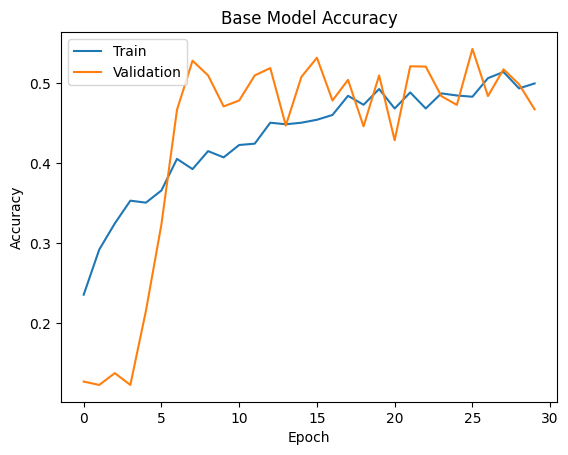

In [51]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

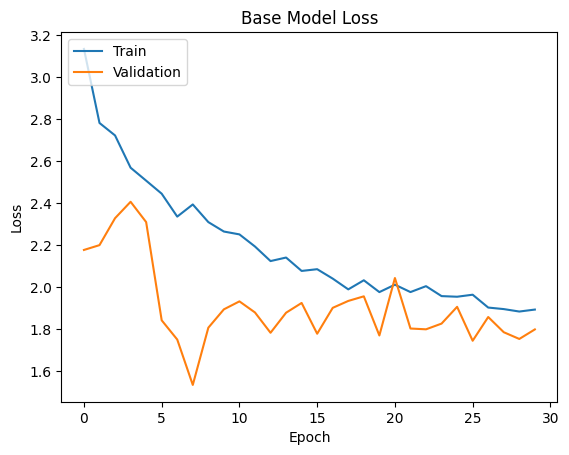

In [52]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

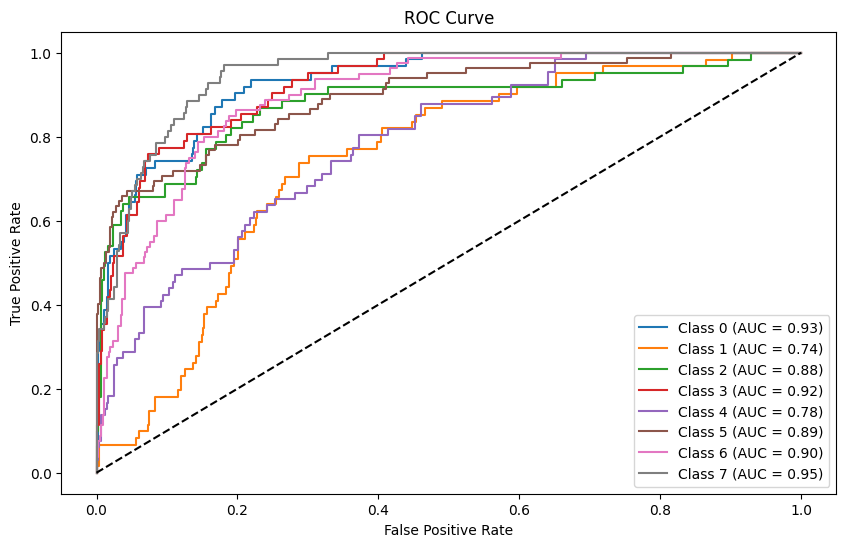

In [53]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

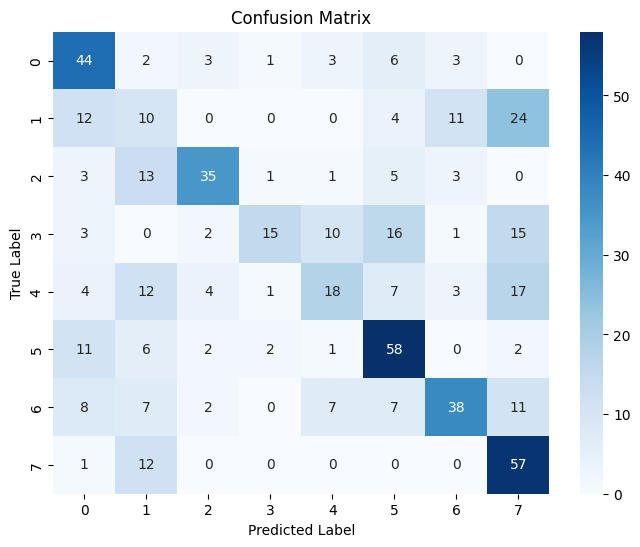

In [55]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [56]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            pred_label = np.argmax(predictions[i])

            ax = plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 images
            plt.imshow((image * 255).numpy().astype("uint8"))  # Denormalize
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=10)
            plt.axis("off")

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


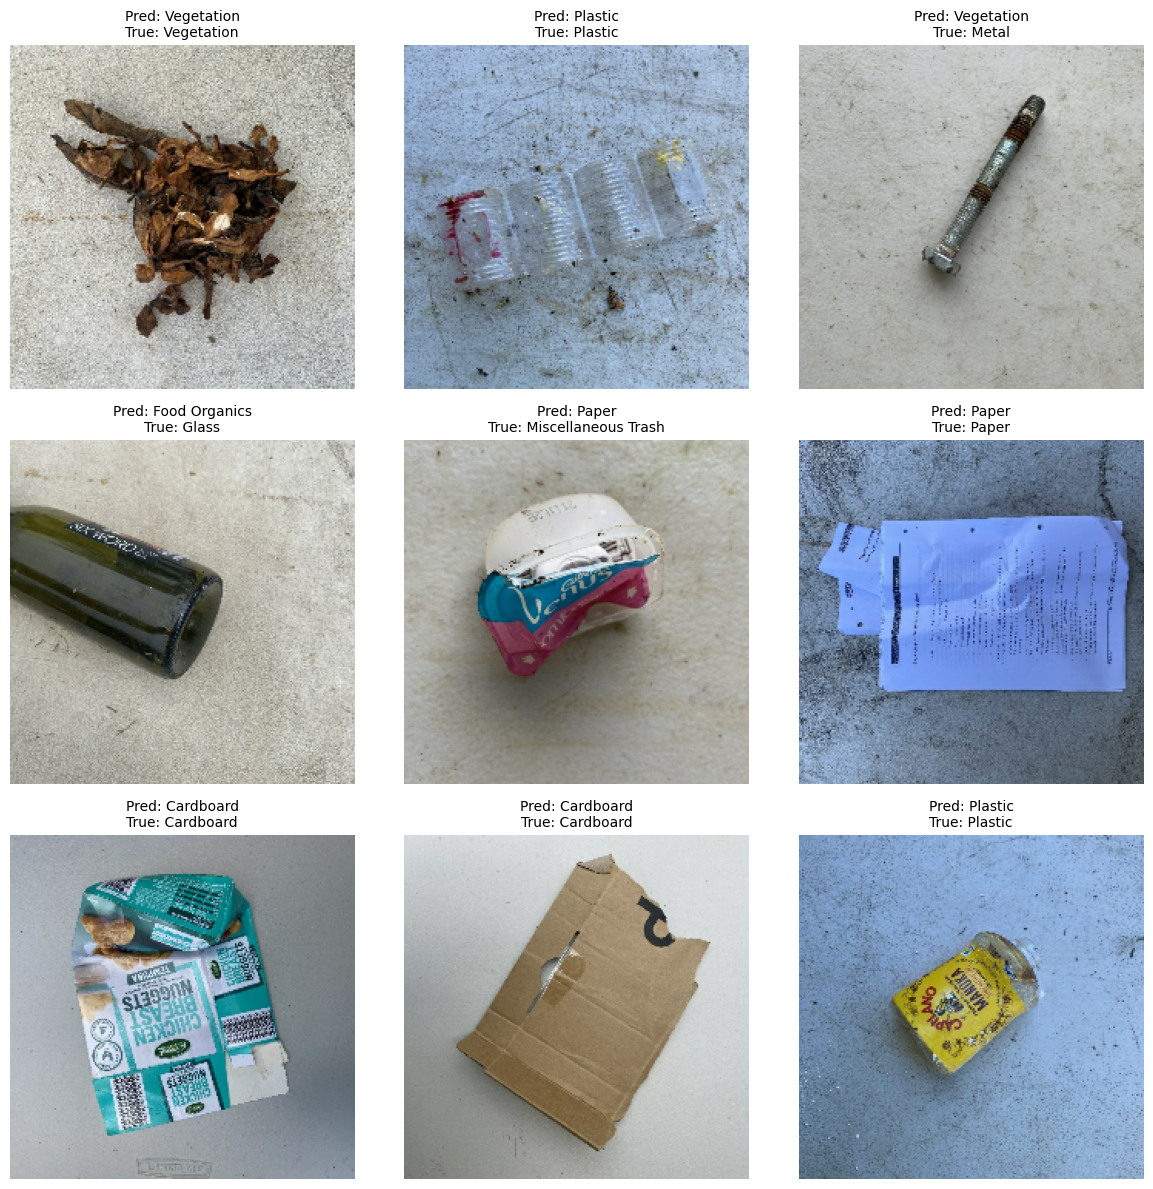

In [57]:
classify_from_dataset(best_model, test_dataset, class_names)

In [115]:
from tensorflow.keras.models import load_model


model = load_model(
    "/content/drive/MyDrive/my_best_model.keras",
)

In [197]:

from tensorflow.keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

In [198]:


# 🔹 Step 1: Feature Extraction
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        # Extract features using model
        batch_features = feature_model.predict(batch_images)

        # Ensure 2D output (batch_size, feature_size)
        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)

        features.append(batch_features)

        # Convert one-hot labels to class indices if necessary
        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)

In [199]:
X, y = extract_features(dataset, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━

In [200]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [201]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [277]:
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca_ = pca.transform(X_test_scaled)

In [278]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
svm = SVC(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(svm, param_grid, cv=stratified_cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
✅ Cross-Validation Accuracy: 0.7502465473283418


In [279]:

y_pred = grid_search.predict(X_test_pca_)
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


📊 Test Accuracy: 0.7670682730923695
📋 Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.84      0.80      0.82        92
      Food Organics       0.73      0.83      0.78        82
              Glass       0.77      0.79      0.78        84
              Metal       0.72      0.78      0.75        98
Miscellaneous Trash       0.63      0.63      0.63        99
              Paper       0.82      0.69      0.75       100
            Plastic       0.73      0.73      0.73       105
         Vegetation       0.93      0.93      0.93        87

           accuracy                           0.77       747
          macro avg       0.77      0.77      0.77       747
       weighted avg       0.77      0.77      0.77       747



In [287]:
def visualize_svm_predictions_on_images(dataset, feature_extractor, scaler, pca, svm_model, class_names, num_images=9):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np

    plt.figure(figsize=(12, 12))
    plotted = 0

    for images, labels in dataset:
        # Step 1: Extract deep features
        features = feature_extractor.predict(images)

        # Step 2: Scale and reduce
        features_scaled = scaler.transform(features)
        features_pca = pca.transform(features_scaled)

        # Step 3: Predict with SVM
        preds = grid_search.best_estimator_(features_pca)

        for i in range(len(images)):
            if plotted >= num_images:
                break

            true_label = int(tf.argmax(labels[i]).numpy()) if len(labels[i]) > 1 else int(labels[i].numpy())
            pred_label = int(preds[i])

            ax = plt.subplot(3, 3, plotted + 1)
            plt.imshow((images[i].numpy() * 255).astype("uint8"))
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=9)
            plt.axis("off")
            plotted += 1

        if plotted >= num_images:
            break

    plt.tight_layout()
    plt.show()


In [288]:


visualize_svm_predictions_on_images(
    dataset=test_dataset,
    feature_extractor=feature_extractor,
    scaler=scaler,
    pca=pca,
    svm_model=grid_search.best_estimator_,
    class_names=class_names,
    num_images=9
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


TypeError: 'SVC' object is not callable

<Figure size 1200x1200 with 0 Axes>

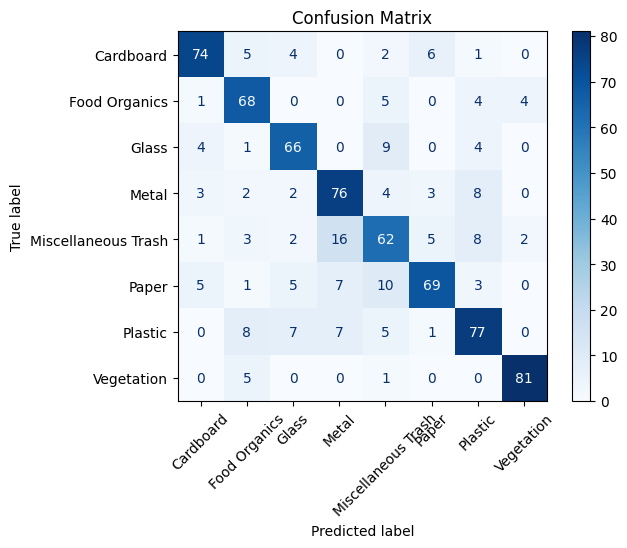

In [283]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

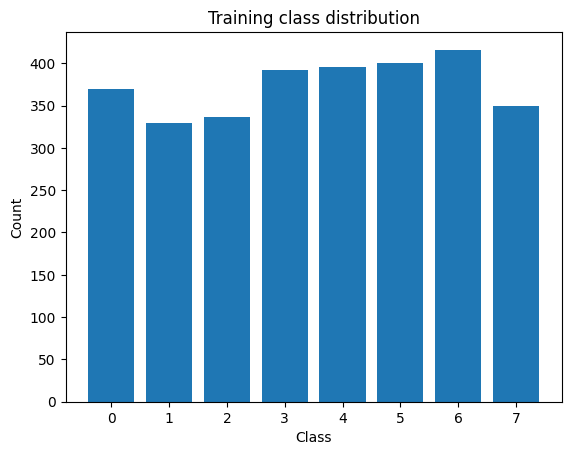

In [216]:
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title("Training class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [248]:
from sklearn.utils import shuffle

def sample_misclassified(X, y_true, y_pred, images, max_samples=9):
    misclassified_idx = np.where(y_true != y_pred)[0]
    misclassified_idx = shuffle(misclassified_idx)[:max_samples]
    return misclassified_idx, images[misclassified_idx], y_true[misclassified_idx], y_pred[misclassified_idx]



In [250]:
# Get the decision scores from your best model
probs = grid_search.best_estimator_.decision_function(X_test_pca_)

# Take the maximum score across all classes for each sample = confidence
confidences = np.max(probs, axis=1)


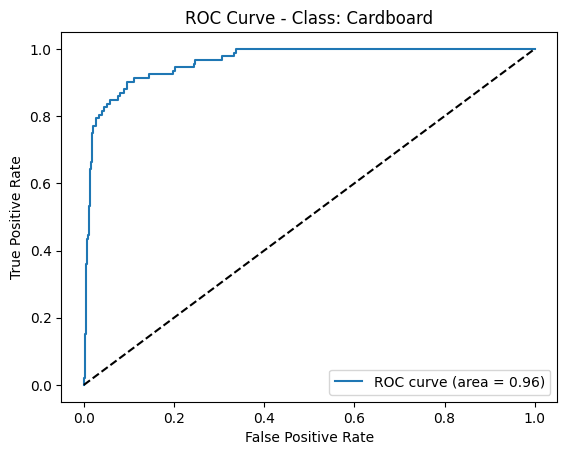

In [252]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# One-hot the labels
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
y_score = grid_search.best_estimator_.decision_function(X_test_pca_)

# ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot for one class (e.g. 0)
plt.figure()
plt.plot(fpr[0], tpr[0], label=f"ROC curve (area = {roc_auc[0]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - Class: " + class_names[0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()




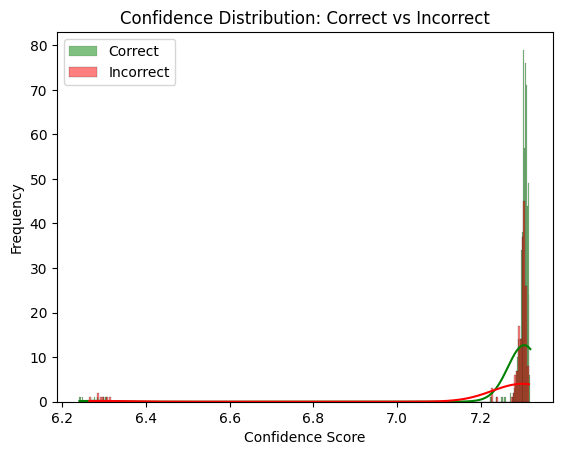

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

correct = (y_pred == y_test)
sns.histplot(confidences[correct], label='Correct', color='green', kde=True)
sns.histplot(confidences[~correct], label='Incorrect', color='red', kde=True)
plt.title("Confidence Distribution: Correct vs Incorrect")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


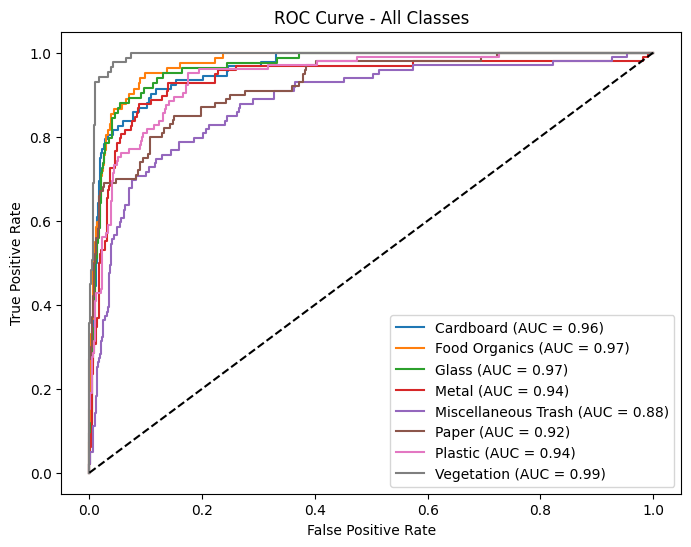

In [286]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

# Decision function for ROC
probs = grid_search.decision_function(X_test_pca_)

# Plot macro-average ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Classes')
plt.legend()
plt.show()


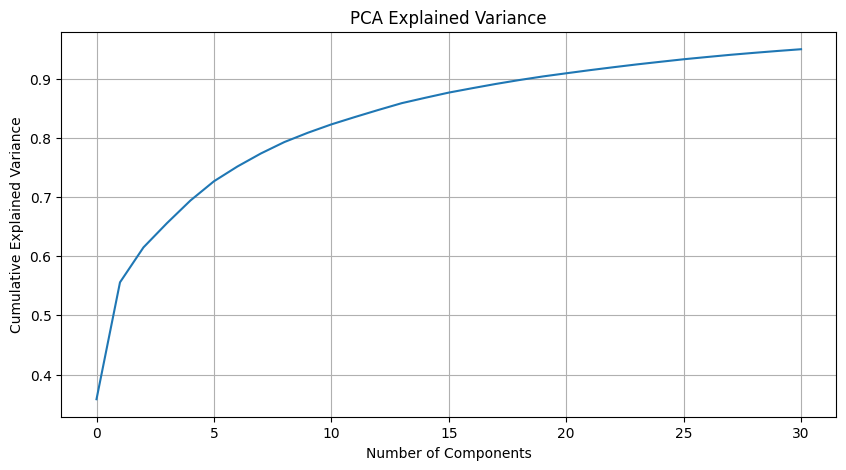

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

